# Pipeline Example

In [1]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.data.builtin import USEquityPricing

## Getting the Securities we want.

### The Q500US and Q1500US

These gropus of tradeable stocks are refered to as "universes", because all your trades will use these stocks as their "Universe" of available stock, they won't be trading with anything outside these groups.

In [2]:
from quantopian.pipeline.filters import Q1500US

There are two main benefits of the Q500US and Q1500US. Firstly, they greatly reduce the risk of an order not being filled. Secondly, they allow for more meaningful comparisons between strategies as now they will be used as the standard universes for algorithms.

In [3]:
universe = Q1500US()

## Filtering the universe further with Classifiers

Let's only grab stocks in the energy sector: https://www.quantopian.com/help/fundamentals#industry-sector

In [4]:
from quantopian.pipeline.data import morningstar

In [5]:
sector = morningstar.asset_classification.morningstar_sector_code.latest

In [6]:
# Alternative:
# from quantopian.pipeline.classifiers.morningstar import Sector
# morningstar_sector = Sector()

In [7]:
energy_sector = sector.eq(309)

## Masking Filters

Masks can be also be applied to methods that return filters like top, bottom, and percentile_between.

Masks are most useful when we want to apply a filter in the earlier steps of a combined computation. For example, suppose we want to get the 50 securities with the highest open price that are also in the top 10% of dollar volume. 

Suppose that we then want the 90th-100th percentile of these securities by close price. We can do this with the following:

In [8]:
from quantopian.pipeline.factors import SimpleMovingAverage, AverageDollarVolume

In [9]:
# Dollar volume factor
dollar_volume = AverageDollarVolume(window_length=30)

# High dollar volume filter
high_dollar_volume = dollar_volume.percentile_between(90,100)

# Top open price filter (high dollar volume securities)
top_open_price = USEquityPricing.open.latest.top(50, mask=high_dollar_volume)

# Top percentile close price filter (high dollar volume, top 50 open price)
high_close_price = USEquityPricing.close.latest.percentile_between(90, 100, mask=top_open_price)

## Applying Filters and Factors

Let's apply our own filters, following along with some of the examples above. Let's select the following securities:

* Stocks in Q1500US
* Stocks that are in the energy Sector
* They must be relatively highly traded stocks in the market (by dollar volume traded, need to be in the top 5% traded)

Then we'll calculate the percent difference as we've done previously. Using this percent difference we'll create an unsophisticated strategy that shorts anything with negative percent difference (the difference between the 10 day mean and the 30 day mean).

In [10]:
def make_pipeline():
    
    # Base universe filter.
    base_universe = Q1500US()
    
    # Sector Classifier as Filter
    energy_sector = sector.eq(309)
    
    # Masking Base Energy Stocks
    base_energy = base_universe & energy_sector
    
    # Dollar volume factor
    dollar_volume = AverageDollarVolume(window_length=30)

    # Top half of dollar volume filter
    high_dollar_volume = dollar_volume.percentile_between(95,100)
    
    # Final Filter Mask
    top_half_base_energy = base_energy & high_dollar_volume
    
    # 10-day close price average.
    mean_10 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=10, mask=top_half_base_energy)

    # 30-day close price average.
    mean_30 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=30, mask=top_half_base_energy)

    # Percent difference factor.
    percent_difference = (mean_10 - mean_30) / mean_30
    
    # Create a filter to select securities to short.
    shorts = percent_difference < 0
    
    # Create a filter to select securities to long.
    longs = percent_difference > 0
    
    # Filter for the securities that we want to trade.
    securities_to_trade = (shorts | longs)
    
    return Pipeline(
        columns={
            'longs': longs,
            'shorts': shorts,
            'percent_diff':percent_difference
        },
        screen=securities_to_trade
    )

In [11]:
result = run_pipeline(make_pipeline(), '2015-05-05', '2015-05-05')
result

longs  percent_diff shorts
2015-05-05 00:00:00+00:00 Equity(216 [HES])     True      0.036528  False
                          Equity(448 [APA])     True      0.035926  False
                          Equity(455 [APC])     True      0.049153  False
                          Equity(858 [BHI])     True      0.033807  False
                          Equity(1746 [COG])    True      0.058078  False
                          Equity(2368 [DVN])    True      0.046264  False
                          Equity(2564 [EOG])    True      0.032102  False
                          Equity(2621 [ESV])    True      0.060197  False
                          Equity(3443 [HAL])    True      0.049257  False
                          Equity(3647 [HP])     True      0.040991  False
                          Equity(5035 [MRO])    True      0.061598  False
                          Equity(5213 [NBL])    True      0.010443  False
                          Equity(5214 [NBR])    True      0.064133  False
                          Equity(5249 [NE])     True      0.037559  False
                          Equity(5729 [OXY])    True      0.029776  False
                          Equity(6928 [SLB])    True      0.046555  False
                          Equity(7244 [SWN])    True      0.070788  False
                          Equity(7612 [ANDV])   True      0.005997  False
                          Equity(7990 [VLO])   False     -0.017145   True
                          Equity(8214 [WMB])    True      0.018876  False
                          Equity(8347 [XOM])    True      0.017343  False
                          Equity(8461 [CHK])    True      0.014265  False
                          Equity(9038 [RIG])    True      0.048180  False
                          Equity(13176 [CAM])   True      0.082110  False
                          Equity(17436 [PXD])   True      0.010248  False
                          Equity(19249 [RRC])   True      0.087062  False
                          Equity(19336 [WFT])   True      0.049141  False
                          Equity(22784 [FTI])   True      0.054529  False
                          Equity(23112 [CVX])   True      0.018972  False
                          Equity(23998 [COP])   True      0.023902  False
                          Equity(24809 [NOV])   True      0.024940  False
                          Equity(25707 [WLL])   True      0.048205  False
                          Equity(33856 [CLR])   True      0.064304  False
                          Equity(34440 [CXO])   True      0.042184  False
                          Equity(39797 [OAS])   True      0.042388  False
                          Equity(40852 [KMI])   True      0.023016  False
                          Equity(41636 [MPC])   True      0.011952  False
                          Equity(42788 [PSX])   True      0.020911  False

In [12]:
result.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 38 entries, (2015-05-05 00:00:00+00:00, Equity(216 [HES])) to (2015-05-05 00:00:00+00:00, Equity(42788 [PSX]))
Data columns (total 3 columns):
longs           38 non-null bool
percent_diff    38 non-null float64
shorts          38 non-null bool
dtypes: bool(2), float64(1)
memory usage: 684.0+ bytes


## Executing this Strategy in the IDE

In [ ]:
from quantopian.algorithm import attach_pipeline,pipeline_output
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import AverageDollarVolume,SimpleMovingAverage
from quantopian.pipeline.filters.morningstar import Q1500US
from quantopian.pipeline.data import morningstar

def initialize(context):
    
    schedule_function(my_rebalance,date_rules.week_start(),time_rules.market_open(hours=1))
    
    my_pipe = make_pipeline()
    attach_pipeline(my_pipe,'my_pipeline')
    
def my_rebalance(context,data):
    
    for security in context.portfolio.positions:
        if security not in context.longs and security not in context.shorts and data.can_trade(security):
            order_target_percent(security,0)
            
    for security in context.longs:
        if data.can_trade(security):
            order_target_percent(security,context.long_weight)

    for security in context.shorts:
        if data.can_trade(security):
            order_target_percent(security,context.short_weight)

def my_compute_weights(context):
    
    if len(context.longs)==0:
        long_weight = 0
    else:
        long_weight = 0.5 / len(context.longs)
  
    if len(context.shorts)==0:
        short_weight = 0
    else:
        short_weight = 0.5 / len(context.shorts)
    
    return (long_weight,short_weight)

def before_trading_start(context,data):
    
    context.output = pipeline_output('my_pipeline')
    
    # LONG
    context.longs = context.output[context.output['longs']].index.tolist()
    
    # SHORT
    context.shorts = context.output[context.output['shorts']].index.tolist()

    context.long_weight,context.short_weight = my_compute_weights(context)

def make_pipeline():
    
    # Universe Q1500US
    base_universe = Q1500US()
    
    # Energy Sector
    sector = morningstar.asset_classification.morningstar_sector_code.latest
    energy_sector = sector.eq(309)
    
    # Make Mask of 1500US and Energy
    base_energy = base_universe & energy_sector
    
    # Dollar Volume (30 Days) Grab the Info
    dollar_volume = AverageDollarVolume(window_length=30)
    
    # Grab the top 5% in avg dollar volume
    high_dollar_volume = dollar_volume.percentile_between(95,100)
     
    # Combine the filters
    top_five_base_energy = base_energy & high_dollar_volume
    
    # 10 day mean close
    mean_10 = SimpleMovingAverage(inputs=[USEquityPricing.close],window_length=10,mask=top_five_base_energy)
    
    # 30 day mean close
    mean_30 = SimpleMovingAverage(inputs=[USEquityPricing.close],window_length=30,mask=top_five_base_energy)
    
    # Percent Difference
    percent_difference = (mean_10-mean_30)/mean_30
    
    # List of Shorts
    shorts = percent_difference < 0
    
    # List of Longs
    longs = percent_difference > 0
    
    # Final Mask/Filter for anything in shorts or longs
    securities_to_trade = (shorts | longs)
    
    # Return Pipeline
    return Pipeline(columns={
        'longs':longs,
        'shorts':shorts,
        'perc_diff':percent_difference
    },screen=securities_to_trade)

# Leverage

$ Leverage Ratio = \frac{Debt + Capital Base}{Capital Base}$

## Leverage from Algorithm

The get_backtest function provides programmatic access to the results of backtests run on the Quantopian platform. It takes a single parameter, the ID of a backtest for which results are desired.

You can find the ID of a backtest in the URL of its full results page, which will be of the form:

https://www.quantopian.com/algorithms/<algorithm_id>/<backtest_id>.  

You are only entitled to view the backtests that either:

* 1) you have created
* 2) you are a collaborator on

In [ ]:
def initialize(context):
    context.amzn = sid(16841)
    context.ibm = sid(3766)
    
    schedule_function(rebalance,date_rules.every_day(),time_rules.market_open())
    schedule_function(record_vars,date_rules.every_day(),time_rules.market_close())
    
def rebalance(context,data):
    order_target_percent(context.amzn,0.5)
    order_target_percent(context.ibm,-0.5)
    
def record_vars(context,data):
    record(amzn_close=data.current(context.amzn,'close'))
    record(ibm_close=data.current(context.ibm,'close'))
    record(Leverage = context.account.leverage)
    record(Exposure = context.account.net_leverage)

## Backtest Info

In [13]:
bt = get_backtest('5b1d6806dca9ad444384e611')

100% Time: 0:00:02|###########################################################|


In [14]:
bt.benchmark_security

8554

In [15]:
bt.algo_id

'5b1d6806dca9ad444384e611'

In [16]:
bt.recorded_vars

,Exposure,Leverage,amzn_close,ibm_close
2011-01-04 00:00:00+00:00,-0.004636,1.003402,185.010,147.688
2011-01-05 00:00:00+00:00,0.007897,0.997989,187.380,146.990
2011-01-06 00:00:00+00:00,-0.006598,1.010934,185.840,148.730
2011-01-07 00:00:00+00:00,-0.003579,0.993752,185.410,147.931
2011-01-10 00:00:00+00:00,-0.001049,1.003124,184.750,147.740
2011-01-11 00:00:00+00:00,0.001584,0.994162,184.271,147.260
2011-01-12 00:00:00+00:00,-0.006117,1.007942,184.150,149.110
2011-01-13 00:00:00+00:00,0.005937,0.997760,185.619,148.760
2011-01-14 00:00:00+00:00,0.003332,1.008790,188.770,149.970
2011-01-18 00:00:00+00:00,0.003417,1.006948,191.300,150.640


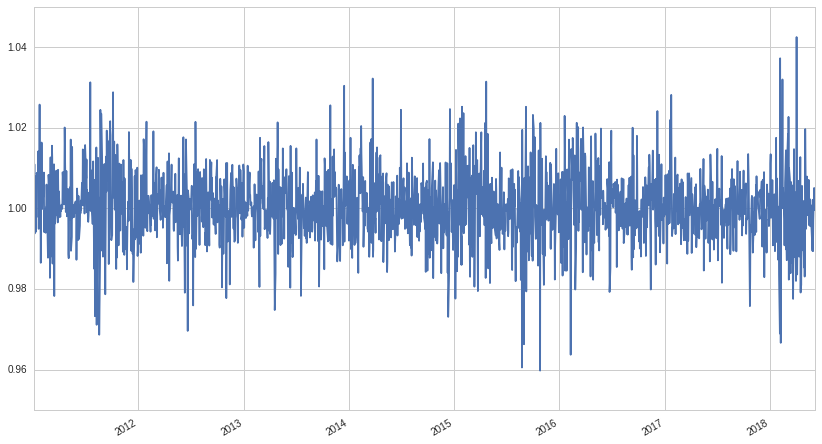

In [17]:
bt.recorded_vars['Leverage'].plot()

##  High Leverage Example

In [ ]:
def initialize(context):
    context.amzn = sid(16841)
    context.ibm = sid(3766)
    
    schedule_function(rebalance,date_rules.every_day(),time_rules.market_open())
    schedule_function(record_vars,date_rules.every_day(),time_rules.market_close())
    
def rebalance(context,data):
    order_target_percent(context.amzn,2.0)
    order_target_percent(context.ibm,-2.0)
    
def record_vars(context,data):
    record(amzn_close=data.current(context.amzn,'close'))
    record(ibm_close=data.current(context.ibm,'close'))
    record(Leverage = context.account.leverage)
    record(Exposure = context.account.net_leverage)

In [18]:
bt = get_backtest('5b1d6ebdc97eec43de4292fa')

100% Time: 0:00:03|###########################################################|


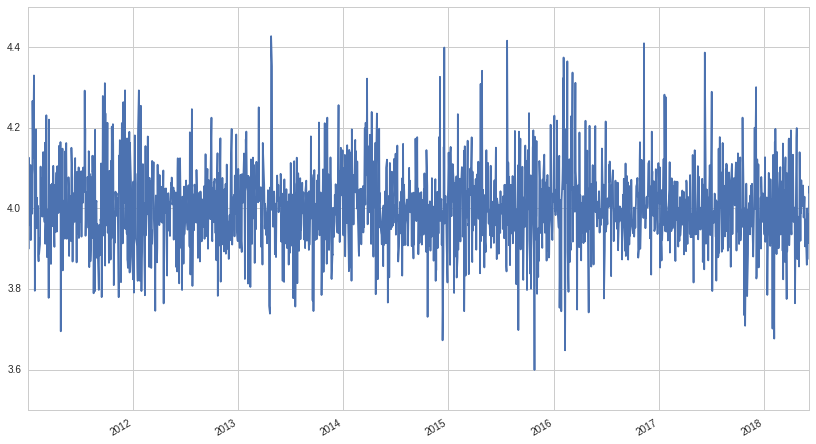

In [19]:
bt.recorded_vars['Leverage'].plot()

## Set Hard Limit on Leverage

In [ ]:
def initialize(context):
    
    set_max_leverage(1.05)
    
    context.amzn = sid(16841)
    context.ibm = sid(3766)
    
    schedule_function(rebalance,date_rules.every_day(),time_rules.market_open())
    schedule_function(record_vars,date_rules.every_day(),time_rules.market_close())
    
def rebalance(context,data):
    order_target_percent(context.amzn,0.5)
    order_target_percent(context.ibm,-0.5)
    
def record_vars(context,data):
    record(amzn_close=data.current(context.amzn,'close'))
    record(ibm_close=data.current(context.ibm,'close'))
    record(Leverage = context.account.leverage)
    record(Exposure = context.account.net_leverage)

# Hedging

In [20]:
import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [21]:
start = '2016-01-01'
end = '2017-01-01'

In [22]:
asset = get_pricing('AAPL', fields='price', start_date=start, end_date=end)

In [23]:
asset.head()

2016-01-04 00:00:00+00:00    103.038
2016-01-05 00:00:00+00:00    100.465
2016-01-06 00:00:00+00:00     98.508
2016-01-07 00:00:00+00:00     94.439
2016-01-08 00:00:00+00:00     94.869
Freq: C, Name: Equity(24 [AAPL]), dtype: float64

In [24]:
benchmark = get_pricing('SPY', fields='price', start_date=start, end_date=end)

In [25]:
asset_ret = asset.pct_change()[1:]
bench_ret = benchmark.pct_change()[1:]

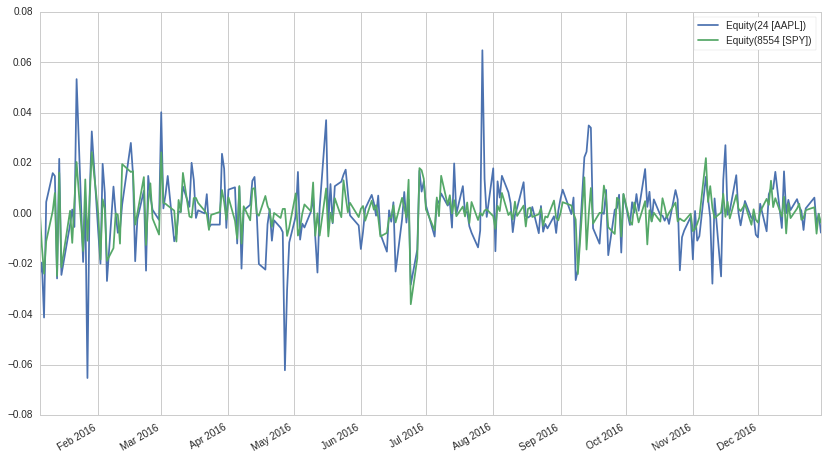

In [26]:
asset_ret.plot()
bench_ret.plot()
plt.legend()

## Regression for Alpha and Beta Values

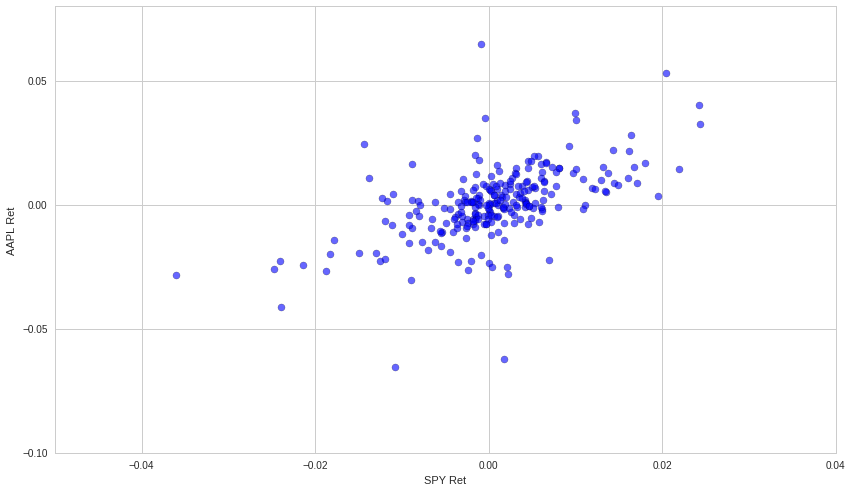

In [27]:
plt.scatter(bench_ret,asset_ret,alpha=0.6,s=50)
plt.xlabel('SPY Ret')
plt.ylabel('AAPL Ret')

In [28]:
AAPL = asset_ret.values
spy = bench_ret.values

In [29]:
AAPL

array([ -2.49713698e-02,  -1.94794207e-02,  -4.13062898e-02,
         4.55320366e-03,   1.59904711e-02,   1.48154296e-02,
        -2.58040771e-02,   2.16601952e-02,  -2.44160486e-02,
        -4.43265212e-03,   1.55463429e-03,  -5.37469774e-03,
         5.32836486e-02,  -1.92716680e-02,   5.16952549e-03,
        -6.53143021e-02,   6.73842653e-03,   3.25321627e-02,
        -7.61896744e-03,  -1.99147420e-02,   1.96810352e-02,
         8.13853549e-03,  -2.68077045e-02,   1.06420947e-02,
        -1.07012531e-04,  -7.68432206e-03,  -6.47116556e-03,
         3.51718972e-03,   2.79848123e-02,   1.54267074e-02,
        -1.89645167e-02,  -2.28170621e-03,   8.95712017e-03,
        -2.27081934e-02,   1.48928403e-02,   6.86634433e-03,
         1.43955952e-03,  -2.57069409e-03,   4.01430675e-02,
         1.98228084e-03,   7.65100129e-03,   1.48752880e-02,
        -1.10645018e-02,  -8.25398726e-03,   7.95032556e-04,
         5.93286809e-04,   1.06728305e-02,   2.64500283e-03,
         2.00926284e-02,

In [30]:
# Add a constant (column of 1s for intercept)
spy_constant = sm.add_constant(spy)

# Fit regression to data
model = regression.linear_model.OLS(AAPL,spy_constant).fit()

In [31]:
model.params

array([  1.67990248e-05,   1.02981370e+00])

In [32]:
alpha , beta = model.params

In [33]:
alpha

1.6799024809993564e-05

In [34]:
beta

1.0298136979465768

### Plot Alpha and Beta

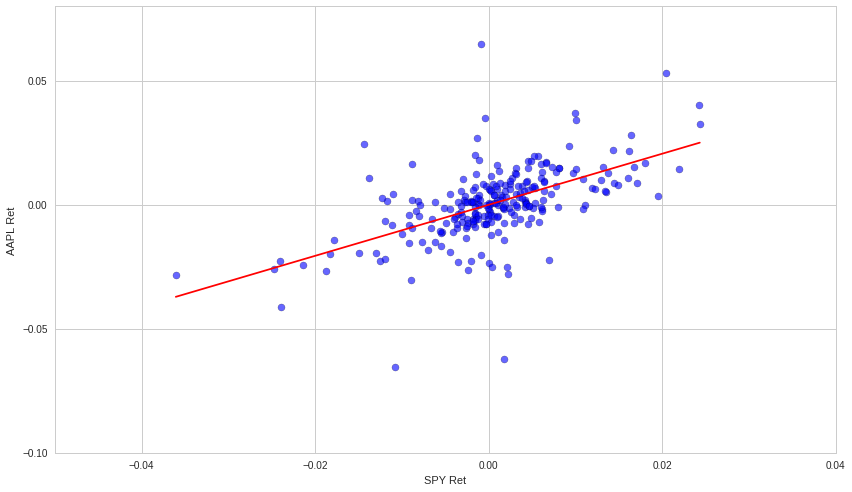

In [35]:
# Scatter Returns
plt.scatter(bench_ret,asset_ret,alpha=0.6,s=50)

# Fit Line
min_spy = bench_ret.values.min()
max_spy = bench_ret.values.max()

spy_line = np.linspace(min_spy,max_spy,100)
y = spy_line * beta + alpha

plt.plot(spy_line,y,'r')

plt.xlabel('SPY Ret')
plt.ylabel('AAPL Ret')

## Implementing the Hedge

In [36]:
hedged = -1*beta*bench_ret + asset_ret

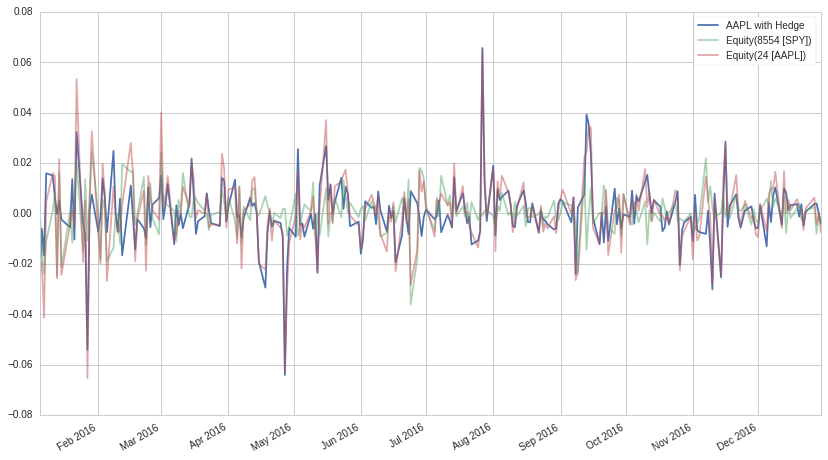

In [37]:
hedged.plot(label='AAPL with Hedge')
bench_ret.plot(alpha=0.5)
asset_ret.plot(alpha=0.5)
plt.legend()

**What happens if there is a big market drop?**

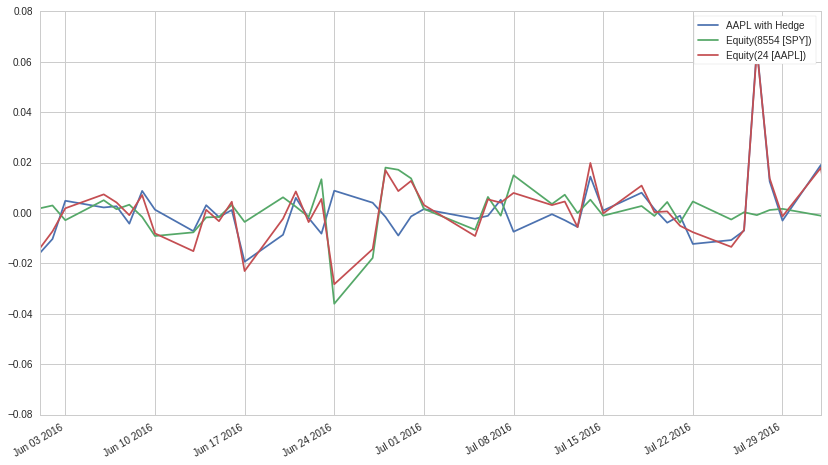

In [38]:
hedged.plot(label='AAPL with Hedge')
bench_ret.plot()
asset_ret.plot()
plt.xlim(['2016-06-01','2016-08-01'])
plt.legend()

### Effects of Hedging

In [39]:
def alpha_beta(benchmark_ret,stock):
    
    benchmark = sm.add_constant(benchmark_ret)
    
    model = regression.linear_model.OLS(stock,benchmark).fit()
    
    return model.params[0], model.params[1]

** 2016-2017 Alpha and Beta **

In [40]:
# Get the alpha and beta estimates over the last year
start = '2016-01-01'
end = '2017-01-01'

asset2016 = get_pricing('AAPL', fields='price', start_date=start, end_date=end)
benchmark2016 = get_pricing('SPY', fields='price', start_date=start, end_date=end)

asset_ret2016 = asset2016.pct_change()[1:]
benchmark_ret2016 = benchmark2016.pct_change()[1:]

aret_val = asset_ret2016.values
bret_val = benchmark_ret2016.values

alpha2016, beta2016 = alpha_beta(bret_val,aret_val)

print('2016 Based Figures')
print('alpha: ' + str(alpha2016))
print('beta: ' + str(beta2016))

2016 Based Figures
alpha: 1.679902481e-05
beta: 1.02981369795


** Creating a Portfolio **

In [41]:
# Create hedged portfolio and compute alpha and beta
portfolio = -1*beta2016*benchmark_ret2016 + asset_ret2016

alpha, beta = alpha_beta(benchmark_ret2016,portfolio)
print('Portfolio with Alphas and Betas:')
print('alpha: ' + str(alpha))
print('beta: ' + str(beta))

Portfolio with Alphas and Betas:
alpha: 1.679902481e-05
beta: 1.36609473733e-16


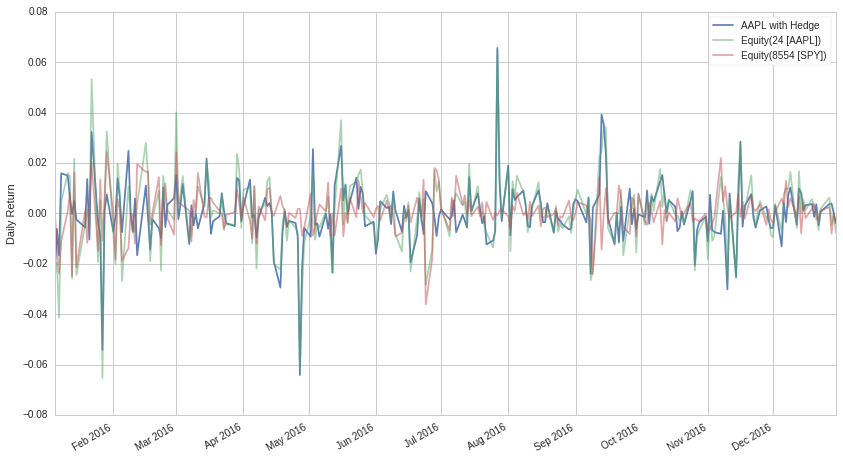

In [42]:
# Plot the returns of the portfolio as well as the asset by itself
portfolio.plot(alpha=0.9,label='AAPL with Hedge')
asset_ret2016.plot(alpha=0.5);
benchmark_ret2016.plot(alpha=0.5)
plt.ylabel("Daily Return")
plt.legend();

In [43]:
portfolio.mean()

1.6799024809993652e-05

In [44]:
asset_ret2016.mean()

0.000574549568770769

In [45]:
portfolio.std()

0.012065447808277703

In [47]:
asset_ret2016.std()

0.014702747344261722

** 2017 Based Figures **

In [48]:
# Get data for a different time frame:
start = '2017-01-01'
end = '2017-08-01'

asset2017 = get_pricing('AAPL', fields='price', start_date=start, end_date=end)
benchmark2017 = get_pricing('SPY', fields='price', start_date=start, end_date=end)

asset_ret2017 = asset2017.pct_change()[1:]
benchmark_ret2017 = benchmark2017.pct_change()[1:]

aret_val = asset_ret2017.values
bret_val = benchmark_ret2017.values

alpha2017, beta2017 = alpha_beta(bret_val,aret_val)

print('2017 Based Figures')
print('alpha: ' + str(alpha2017))
print('beta: ' + str(beta2017))

2017 Based Figures
alpha: 0.000968854542346
beta: 1.26769880296


** Creating a Portfolio based off 2016 Beta estimate **

In [49]:
# Create hedged portfolio and compute alpha and beta
portfolio = -1*beta2016*benchmark_ret2017 + asset_ret2017

alpha, beta = alpha_beta(benchmark_ret2017,portfolio)
print 'Portfolio with Alphas and Betas Out of Sample:'
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

Portfolio with Alphas and Betas Out of Sample:
alpha: 0.000968854542346
beta: 0.23788510501


In [51]:
portfolio.mean()

0.0011399935632582228

In [52]:
asset_ret2017.mean()

0.0018808609159293456

In [53]:
portfolio.std()

0.009066375411652783

In [54]:
asset_ret2017.std()

0.010484461271996029

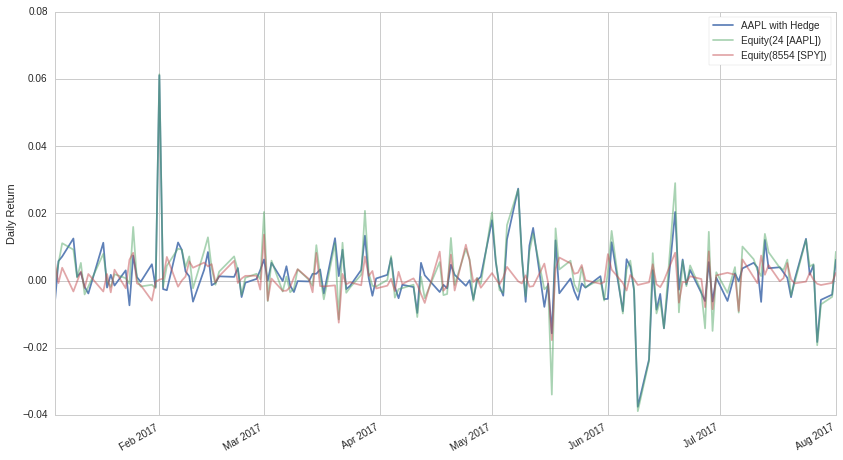

In [50]:
# Plot the returns of the portfolio as well as the asset by itself
portfolio.plot(alpha=0.9,label='AAPL with Hedge')
asset_ret2017.plot(alpha=0.5);
benchmark_ret2017.plot(alpha=0.5)
plt.ylabel("Daily Return")
plt.legend();

# PyFolio Portfolio Analysis

In [55]:
import pyfolio as pf
import matplotlib.pyplot as plt
import empyrical

## Use Algo from Leverage Lecture

In [ ]:
def initialize(context):
    
    #set_max_leverage(1.05)
    
    context.amzn = sid(16841)
    context.ibm = sid(3766)
    
    schedule_function(rebalance,date_rules.every_day(),time_rules.market_open())
    schedule_function(record_vars,date_rules.every_day(),time_rules.market_close())
    
def rebalance(context,data):
    order_target_percent(context.amzn,0.5)
    order_target_percent(context.ibm,-0.5)
    
def record_vars(context,data):
    record(amzn_close=data.current(context.amzn,'close'))
    record(ibm_close=data.current(context.ibm,'close'))
    record(Leverage = context.account.leverage)
    record(Exposure = context.account.net_leverage)

In [56]:
bt = get_backtest('5b1d825ec4fc6842b2eb93dd')

100% Time: 0:00:00|###########################################################|


In [57]:
bt_returns = bt.daily_performance['returns']
bt_positions = bt.pyfolio_positions
bt_transactions = bt.pyfolio_transactions

## Set A Benchmark Algo for SPY

In [ ]:
def initialize(context):
    context.spy = sid(8554)

    set_max_leverage(1.01)
    
    schedule_function(rebalance,date_rules.every_day(),time_rules.market_open())
    
def rebalance(context,data):
    order_target_percent(context.spy,1)

In [58]:
benchmark_rets = get_backtest('5b1d8344ca6115447bd67b55')

100% Time: 0:00:00|###########################################################|


In [59]:
bm_returns = benchmark_rets.daily_performance['returns']
bm_positions = benchmark_rets.pyfolio_positions
bm_transactions = benchmark_rets.pyfolio_transactions

In [61]:
empyrical.sharpe_ratio(bt_returns)

1.3175719236066508

In [62]:
empyrical.sharpe_ratio(bm_returns)

0.4684586666069403

In [63]:
empyrical.beta(bt_returns,bm_returns)

0.06464573965464868

## PyFolio Plots

In [64]:
benchmark_rets = bm_returns

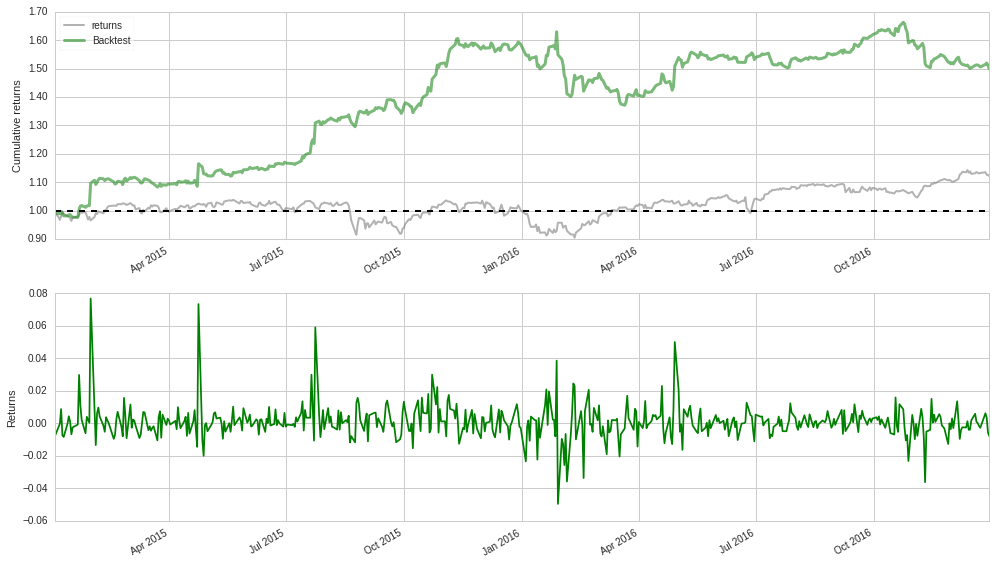

In [65]:
# Cumulative Returns
plt.subplot(2,1,1)
pf.plotting.plot_rolling_returns(bt_returns, benchmark_rets)

# Daily, Non-Cumulative Returns
plt.subplot(2,1,2)
pf.plotting.plot_returns(bt_returns)
plt.tight_layout()

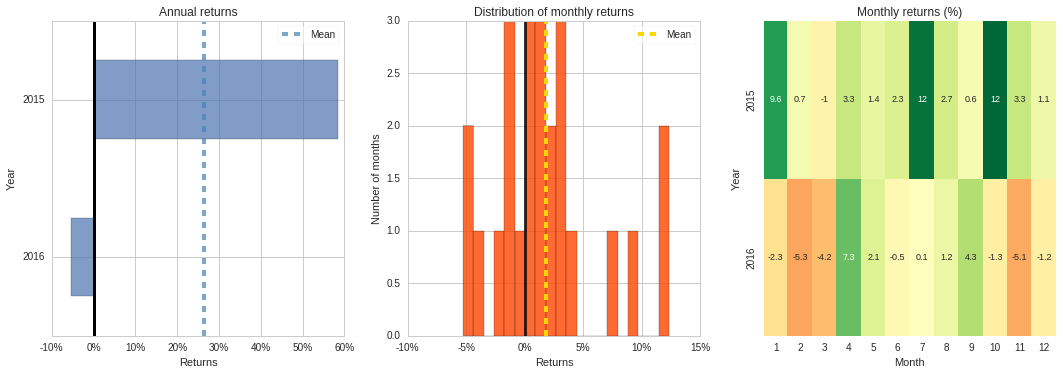

In [66]:
fig = plt.figure(1)
plt.subplot(1,3,1)
pf.plot_annual_returns(bt_returns)
plt.subplot(1,3,2)
pf.plot_monthly_returns_dist(bt_returns)
plt.subplot(1,3,3)
pf.plot_monthly_returns_heatmap(bt_returns)
plt.tight_layout()
fig.set_size_inches(15,5)

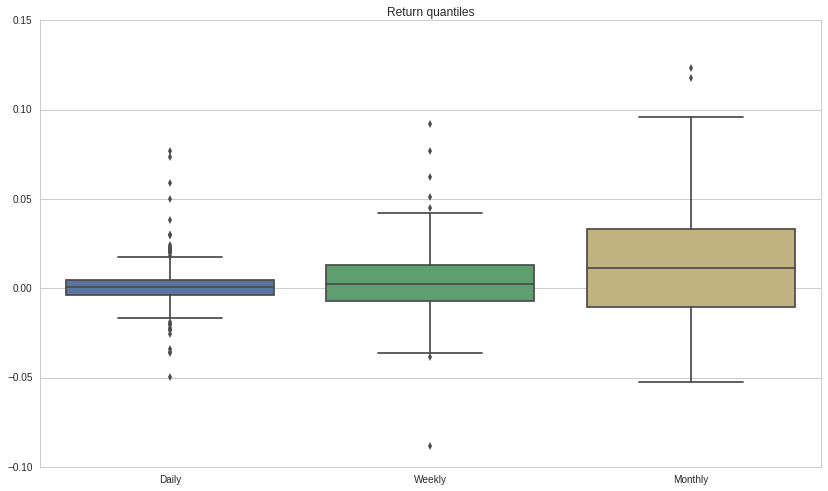

In [67]:
pf.plot_return_quantiles(bt_returns);

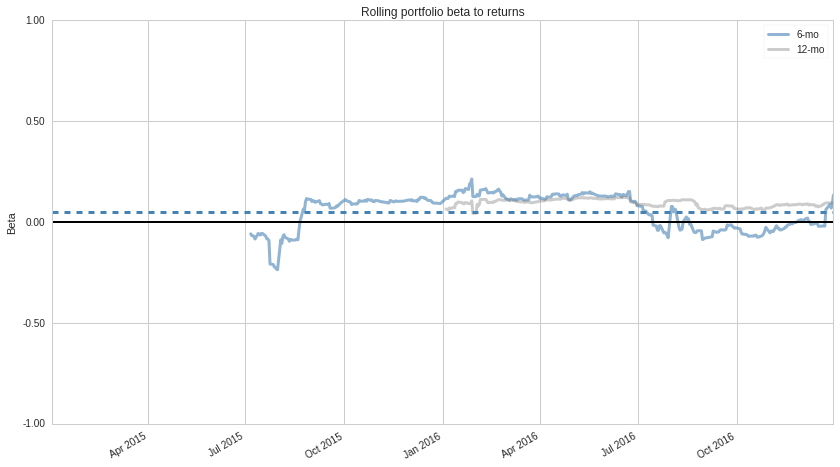

In [68]:
pf.plot_rolling_beta(bt_returns, benchmark_rets);

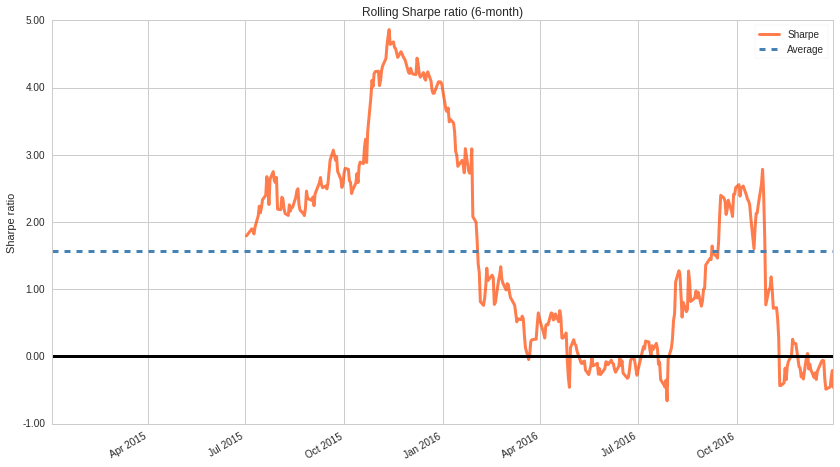

In [69]:
pf.plot_rolling_sharpe(bt_returns);

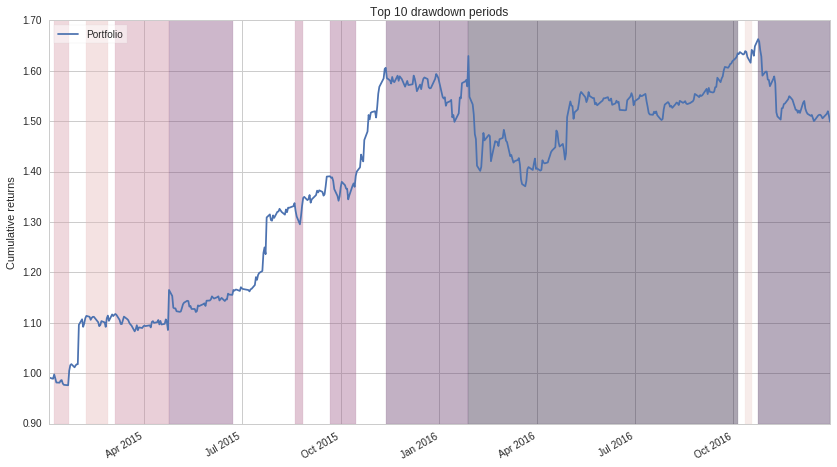

In [71]:
pf.plot_drawdown_periods(bt_returns);

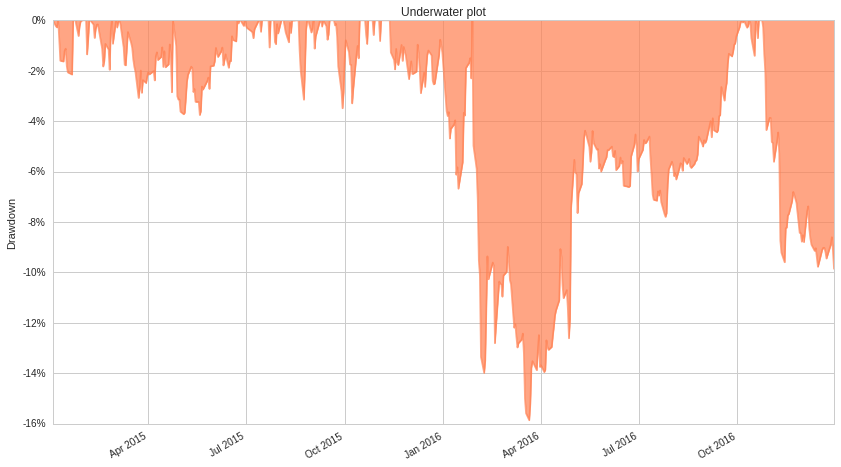

In [72]:
pf.plot_drawdown_underwater(bt_returns);

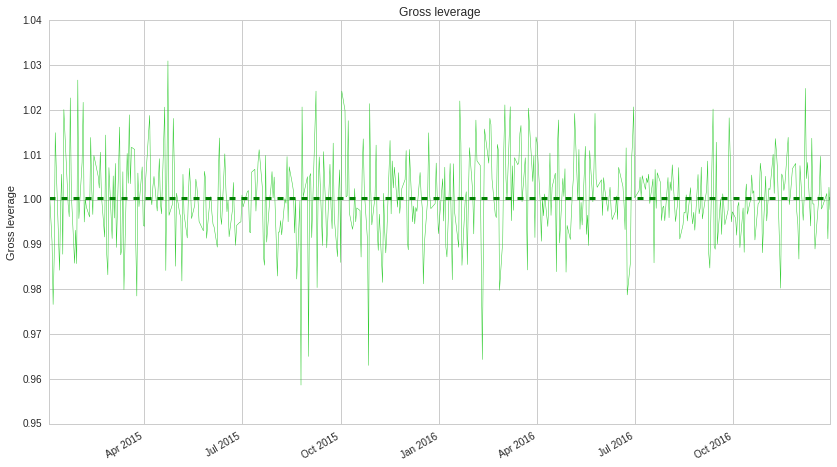

In [73]:
pf.plot_gross_leverage(bt_returns, bt_positions);

Top 10 long positions of all time,max
AMZN-16841,51.61%


Top 10 short positions of all time,max
IBM-3766,-52.26%


Top 10 positions of all time,max
IBM-3766,52.26%
AMZN-16841,51.61%


All positions ever held,max
IBM-3766,52.26%
AMZN-16841,51.61%


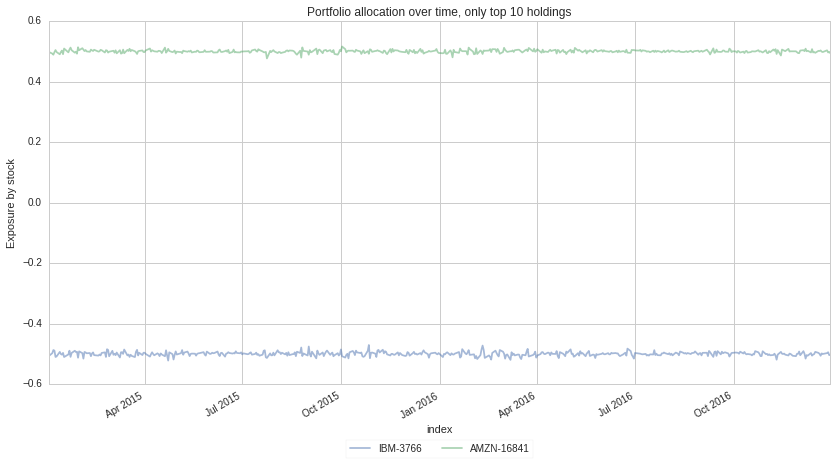

In [74]:
pos_percent = pf.pos.get_percent_alloc(bt_positions)
pf.plotting.show_and_plot_top_positions(bt_returns, pos_percent);

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,518.00,251.00,267.00
Percent profitable,0.70,0.42,0.97
Winning round_trips,365.00,106.00,259.00
Losing round_trips,153.00,145.00,8.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$5339148.14,$-596039.31,$5935187.45
Gross profit,$7248614.13,$1292524.03,$5956090.10
Gross loss,$-1909465.99,$-1888563.34,$-20902.65
Profit factor,$3.80,$0.68,$284.94
Avg. trade net profit,$10307.24,$-2374.66,$22229.17
Avg. winning trade,$19859.22,$12193.62,$22996.49
Avg. losing trade,$-12480.17,$-13024.57,$-2612.83
Ratio Avg. Win:Avg. Loss,$1.59,$0.94,$8.80
Largest winning trade,$874001.42,$94219.96,$874001.42
Largest losing trade,$-591196.15,$-591196.15,$-8581.91


Duration stats,All trades,Short trades,Long trades
Avg duration,207 days 17:05:02.086872,180 days 16:12:54.501992,233 days 03:04:08.992509
Median duration,222 days 23:00:00,191 days 23:00:00,265 days 00:00:00
Longest duration,348 days 00:00:00,273 days 00:00:00,348 days 00:00:00
Shortest duration,0 days 14:31:59,0 days 14:31:59,6 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.07%,-0.02%,0.16%
Avg returns winning,0.14%,0.08%,0.16%
Avg returns losing,-0.08%,-0.09%,-0.03%
Median returns all round_trips,0.04%,-0.00%,0.08%
Median returns winning,0.07%,0.04%,0.08%
Median returns losing,-0.03%,-0.03%,-0.02%
Largest winning trade,5.79%,0.58%,5.79%
Largest losing trade,-3.91%,-3.91%,-0.09%


Symbol stats,AMZN-16841,IBM-3766
Avg returns all round_trips,0.16%,-0.02%
Avg returns winning,0.16%,0.08%
Avg returns losing,-0.02%,-0.09%
Median returns all round_trips,0.08%,-0.00%
Median returns winning,0.08%,0.04%
Median returns losing,-0.02%,-0.03%
Largest winning trade,5.79%,0.58%
Largest losing trade,-0.09%,-3.91%


Profitability (PnL / PnL total) per name,
AMZN-16841,111.15%
IBM-3766,-11.15%


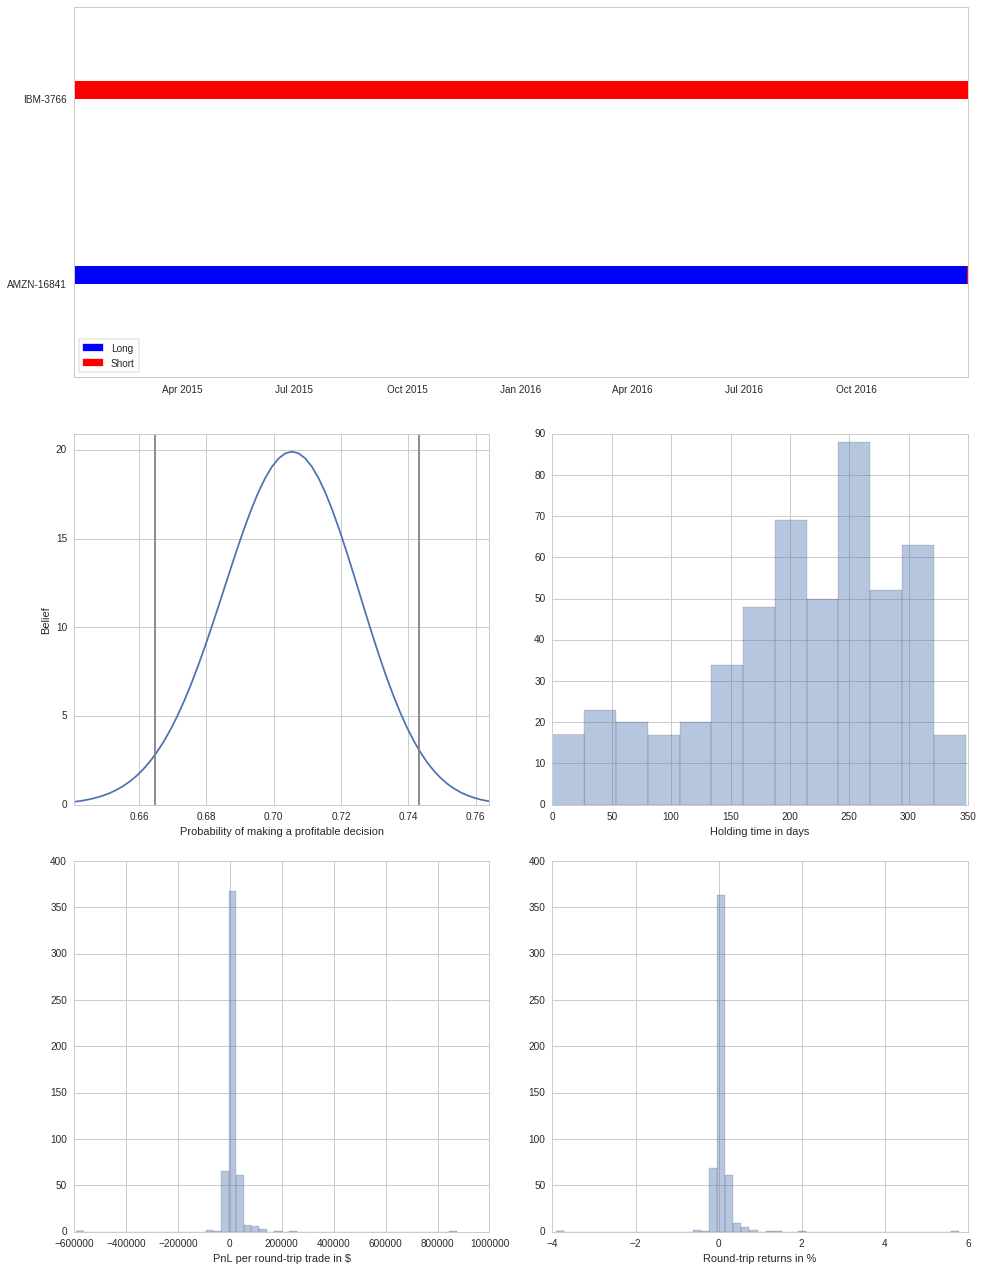

In [78]:
pf.create_round_trip_tear_sheet(bt_returns, bt_positions, bt_transactions);

# Stock Sentiment Analysis

In [ ]:
# This section is only importable in the backtester
from quantopian.algorithm import attach_pipeline, pipeline_output

# General pipeline imports
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import AverageDollarVolume

# Using the free sample in your pipeline algo
from quantopian.pipeline.data.accern import alphaone_free

def initialize(context):
    # Schedule our rebalance function to run at the start of each week.
    schedule_function(my_rebalance, date_rules.every_day())
    
    attach_pipeline(make_pipeline(), "pipeline")

def make_pipeline():
    
    # Screen out penny stocks and low liquidity securities.
    dollar_volume = AverageDollarVolume(window_length=20)
    is_liquid = dollar_volume.rank(ascending=False) < 1000
 
    # Add pipeline factors
    impact = alphaone_free.impact_score.latest
    sentiment = alphaone_free.article_sentiment.latest

    return Pipeline(columns={
            'impact': impact,
            'sentiment':sentiment,
            },
            screen = is_liquid)

def before_trading_start(context, data):
    port = pipeline_output('pipeline')
    
    # Grab stocks with 100 impact and >0.5 sentiment and go long.
    context.longs = port[(port['impact']==100) & (port['sentiment']>0.75)].index.tolist()
    
    # Grab stocks with 100 impact and <-0.5 sentiment and go long.
    context.shorts = port[(port['impact']==100) & (port['sentiment']< -0.75)].index.tolist()

    context.long_weight, context.short_weight = my_compute_weights(context)

def my_compute_weights(context):

    # Compute even target weights for our long positions and short positions.
    long_weight = 0.5 / len(context.longs)
    short_weight = -0.5 / len(context.shorts)

    return long_weight, short_weight

def my_rebalance(context, data):

    for security in context.portfolio.positions:
        if security not in context.longs and security not in context.shorts and data.can_trade(security):
            order_target_percent(security, 0)

    for security in context.longs:
        if data.can_trade(security):
            order_target_percent(security, context.long_weight)

    for security in context.shorts:
        if data.can_trade(security):
            order_target_percent(security, context.short_weight)


# Futures

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Getting Futures

A reference to a futures contract is obtained via the symbols function. Futures contracts are denoted by a base symbol + a code for month/year of delivery. CLF16 is a contract for crude oil (CL) with delivery in January (F) 2016 (16).

### List of all Available Futures (on Quantopian)

Symbol | Future |
--- | --- | 
BD | Big Dow
BO | Soybean Oil
CM | Corn E-Mini
CN | Corn
DJ | DJIA Futures
ET | Ethanol
FF | 30-Day Federal Funds
FI | 5-Year Deliverable Interest Rate Swap Futures
FS | 5-Year Interest Rate Swap Futures
FV | 5-Year T-Note
MB | Municipal Bonds
MS | Soybeans E-Mini
MW | Wheat E-Mini
OA | Oats
RR | Rough Rice
SM | Soybean Meal
SY | Soybeans
TN | 10-Year Deliverable Interest Rate Swap Futures
TS | 10-Year Interest Rate Swap Futures
TU | 2-Year T-Note
TY | 10-Year T-Note
UB | Ultra Tbond
US | 30-Year T-Bond
WC | Wheat
YM | Dow Jones E-mini
VX | VIX Futures
AD | Australian Dollar
AI | Bloomberg Commodity Index Futures
BP | British Pound
CD | Canadian Dollar
EC | Euro FX
ED | Eurodollar
EE | Euro FX E-mini
ES | S&P 500 E-Mini
EU | E-micro EUR/USD Futures
FC | Feeder Cattle
JE | Japanese Yen E-mini
JY | Japanese Yen
LB | Lumber
LC | Live Cattle
LH | Lean Hogs
MD | S&P 400 MidCap Futures
ME | Mexican Peso
MI | S&P 400 MidCap E-Mini
ND | NASDAQ 100 Futures
NK | Nikkei 225 Futures
NQ | NASDAQ 100 E-Mini
NZ | New Zealand Dollar
SF | Swiss Franc
SP | S&P 500 Futures
TB | TBills
GC | Gold
HG | Copper High Grade
SV | Silver
CL | Light Sweet Crude Oil
HO | NY Harbor ULSD Futures
HU | Unleaded Gasoline
NG | Natural Gas
PA | Palladium
PL | Platinum
PB | Pork Bellies
QG | Natural Gas E-mini
QM | Crude Oil E-Mini
XB | RBOB Gasoline Futures
EI | MSCI Emerging Markets Mini
EL | Eurodollar NYSE LIFFE
MG | MSCI EAFE Mini
XG | Gold mini-sized
YS | Silver mini-sized
RM | Russell 1000 Mini
SB | Sugar #11
ER | Russell 2000 Mini

### List of Date/Time Codes

Month | Code |
--- | --- | 
January | F
February | G
March | H
April | J
May | K
June | M
July | N
August | Q
September | U
October | V
November | X
December | Z

In [2]:
future_contract = symbols('NGF18')

In [3]:
future_contract.asset_name

u'Natural Gas'

In [4]:
for key in future_contract.to_dict():
    print(key)
    print(future_contract.to_dict()[key])
    print('\n')

root_symbol
NG


tick_size
0.001


end_date
2017-12-27 00:00:00+00:00


exchange
NYMEX


auto_close_date
2017-12-22 00:00:00+00:00


expiration_date
2017-12-27 00:00:00+00:00


symbol
NGF18


multiplier
10000.0


notice_date
2017-12-28 00:00:00+00:00


first_traded
None


asset_name
Natural Gas


exchange_full
NYMEX


sid
1061201801


start_date
2010-08-24 00:00:00+00:00




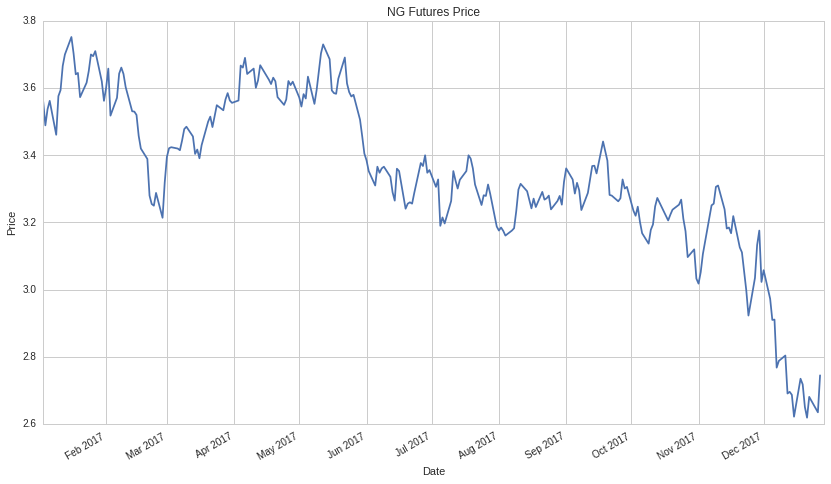

In [5]:
futures_position_value = get_pricing(future_contract, start_date = '2017-01-01', end_date = '2018-01-01', fields = 'price')
futures_position_value.name = futures_position_value.name.symbol
futures_position_value.plot()
plt.title('NG Futures Price')
plt.xlabel('Date')
plt.ylabel('Price');

## Historical Data

In [6]:
from quantopian.research.experimental import history

In [7]:
print history.__doc__


    Load a table of historical trade data.

    Parameters
    ----------
    symbols : Asset-convertible object, ContinuousFuture, or iterable of same.
        Valid input types are Asset, Integral, basestring, or ContinuousFuture.
        In the case that the passed objects are strings, they are interpreted
        as ticker symbols and resolved relative to the date specified by
        symbol_reference_date.

    fields : str or list
        String or list drawn from {'price', 'open_price', 'high', 'low',
        'close_price', 'volume', 'contract'}.

    start : str or pd.Timestamp
        String or Timestamp representing a start date or start intraday minute
        for the returned data.

    end : str or pd.Timestamp
        String or Timestamp representing an end date or end intraday minute for
        the returned data.

    frequency : {'daily', 'minute'}
        Resolution of the data to be returned.

    symbol_reference_date : str or pd.Timestamp, optional
        String 

In [8]:
ngf18 = future_contract

In [10]:
ngf18_data = history(ngf18, 
                     fields=['price', 'open_price', 'high', 'low', 'close_price', 'volume', 'contract'], 
                     frequency='daily', 
                     start='2017-06-01', 
                     end='2017-08-01')

In [11]:
ngf18_data.head()

,price,open_price,high,low,close_price,volume,contract
2017-06-01 00:00:00+00:00,3.385,3.412,3.435,3.341,3.385,5497.0,Future(1061201801 [NGF18])
2017-06-02 00:00:00+00:00,3.353,3.386,3.386,3.336,3.353,2443.0,Future(1061201801 [NGF18])
2017-06-05 00:00:00+00:00,3.310,3.373,3.378,3.298,3.310,2457.0,Future(1061201801 [NGF18])
2017-06-06 00:00:00+00:00,3.366,3.318,3.371,3.307,3.366,2061.0,Future(1061201801 [NGF18])
2017-06-07 00:00:00+00:00,3.348,3.370,3.393,3.342,3.348,1834.0,Future(1061201801 [NGF18])


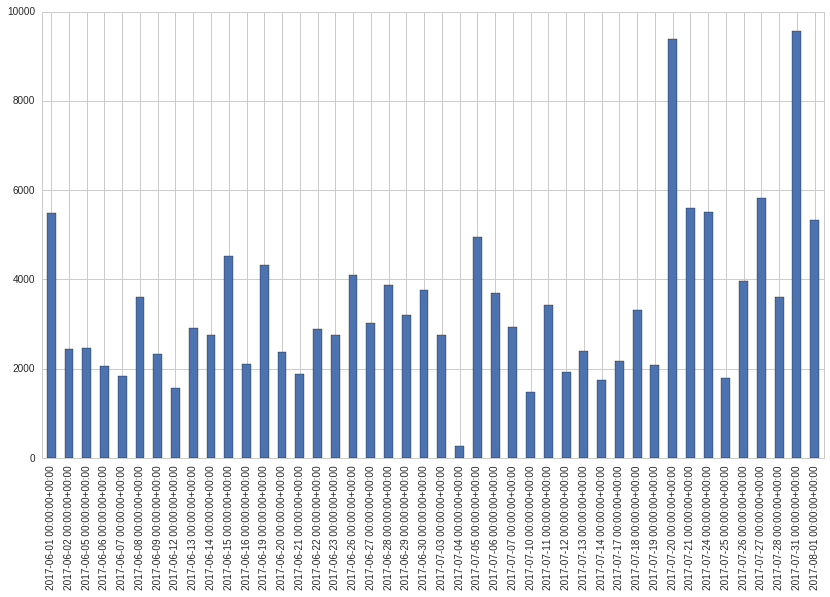

In [12]:
# Notice the 4th of July!
ngf18_data['volume'].plot(kind='bar')

## Comparison of Different Maturity Dates

In [13]:
ng_contracts = symbols(['NGF17', 'NGG17', 'NGH17', 'NGJ17', 'NGK17', 'NGM17'])

In [14]:
ng_consecutive_contract_volume = history(ng_contracts, 
                                         fields='volume', 
                                         frequency='daily', 
                                         start='2016-01-01', 
                                         end='2017-08-01')

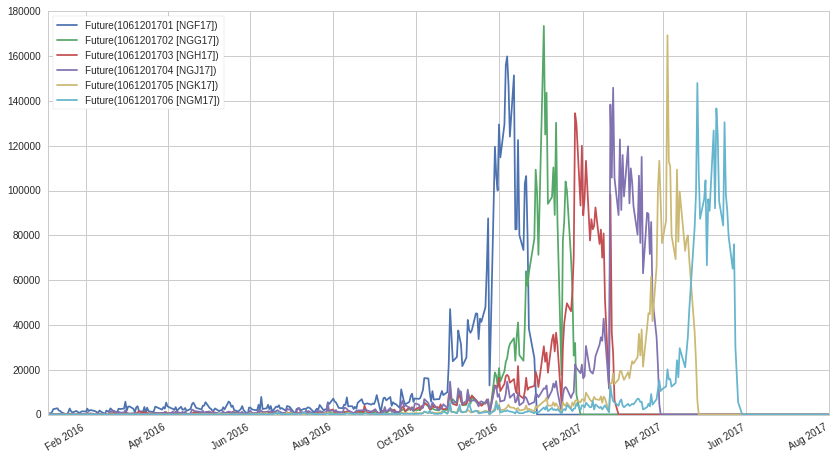

In [15]:
ng_consecutive_contract_volume.plot()

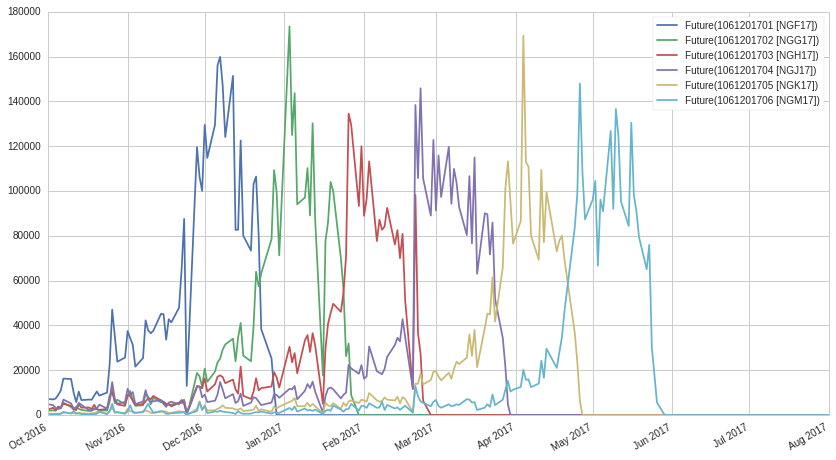

In [16]:
ng_consecutive_contract_volume.plot(xlim=['2016-10-01','2017-08-01'])

# Continuous Futures

Continuous futures are abstractions over the 'underlying' commodities/assets/indexes of futures. For example, if we wanted to trade crude oil, we could create a reference to CL, instead of a series of CL contracts. Continuous futures essentially maintain a reference to a 'current' contract deemed to be the active contract for the particular underlying.

We use the continuous futures objects as part of the platform to get a continuous chain of historical data for futures contracts, taking these concerns into account. There are several ways to adjust for the cost of carry when looking at historical data, though people differ on what they prefer. The general consensus is that an adjustment should be done.

Continuous futures are not tradable assets. They maintain a reference to the current active contract related to a given underlying.

In [17]:
from quantopian.research.experimental import continuous_future

In [18]:
print(continuous_future.__doc__)


    Create a specifier for a continuous contract.

    Parameters
    ----------
    root_symbol : str
        The root symbol for the continuous future.

    offset : int, optional
        The distance from the primary contract. Default is 0.

    roll : str, optional
        How rolls are determined. Options are 'volume' and 'calendar'. Default
        is 'volume'.

    adjustment : str
        Method for adjusting lookback prices between rolls. Options are
        'mul', 'add', and None. Default is 'mul'.

    Returns
    -------
    continuous_future : ContinuousFuture
        The continuous future specifier.
    


There are 4 arguments that we need to consider.

- **`root_symbol`**: The root symbol of the underlying. For example, 'CL' for crude oil.
- **`offset`**: The distance from the primary contract. 0 = primary, 1 = secondary, etc. We'll get into this more later.
- **`roll`**: How to determine the 'current' contract of the continuous future. Current options are **`'volume'`** and **`'calendar'`**. The 'volume' approach chooses the current active contract based on trading volume. The 'calendar' approach chooses the current active contract based simply on the `auto_close_date`s of each contract.**
- **`adjustment`**: How to adjust historical prices from earlier contracts. We'll get into this more later. Options are **`'mul'`**, **`'add'`**, or **`'None'`**.

In [19]:
continuous_ng = continuous_future('NG', offset=0, roll='volume', adjustment='mul')

In [20]:
continuous_ng

ContinuousFuture(94090707563773952, root_symbol='NG', offset=0, roll_style='volume', adjustment='mul')

In [21]:
ng_cont_active = history(continuous_ng, 
                    fields=['contract','price','volume'] ,
                    frequency='daily', 
                    start='2016-10-01', 
                    end='2017-08-01')

In [22]:
ng_cont_active.head()

,price,volume,contract
2016-10-03 00:00:00+00:00,3.960,86282.0,Future(1061201611 [NGX16])
2016-10-04 00:00:00+00:00,4.051,90845.0,Future(1061201611 [NGX16])
2016-10-05 00:00:00+00:00,4.133,119522.0,Future(1061201611 [NGX16])
2016-10-06 00:00:00+00:00,4.139,135372.0,Future(1061201611 [NGX16])
2016-10-07 00:00:00+00:00,4.321,159697.0,Future(1061201611 [NGX16])


In [23]:
ng_cont_active["contract"].unique()

array([Future(1061201611 [NGX16]), Future(1061201612 [NGZ16]),
       Future(1061201701 [NGF17]), Future(1061201702 [NGG17]),
       Future(1061201703 [NGH17]), Future(1061201704 [NGJ17]),
       Future(1061201705 [NGK17]), Future(1061201706 [NGM17]),
       Future(1061201707 [NGN17]), Future(1061201708 [NGQ17]),
       Future(1061201709 [NGU17])], dtype=object)

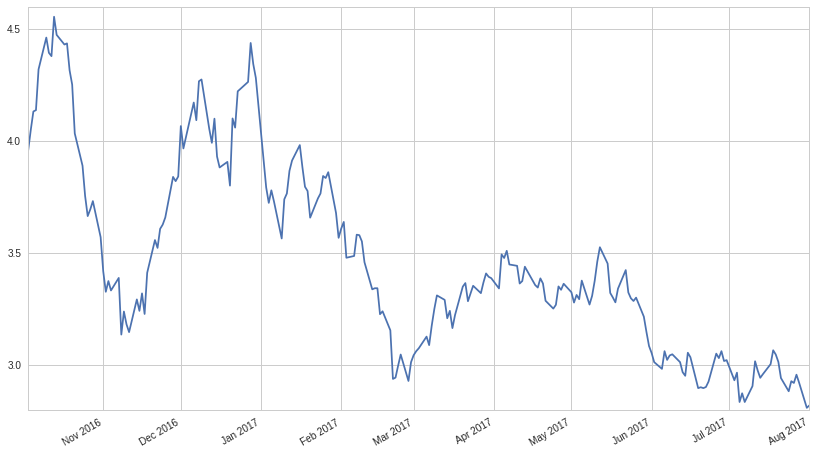

In [24]:
ng_cont_active['price'].plot()

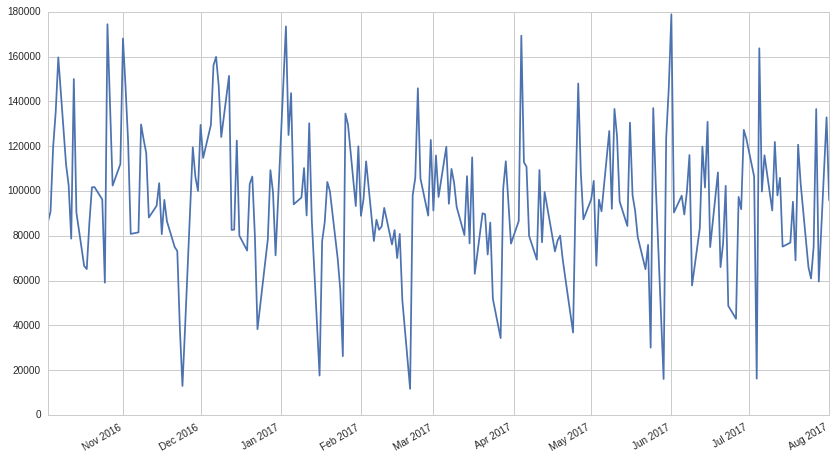

In [25]:
ng_cont_active['volume'].plot()

In [27]:
ng_consecutive_contract_volume = history(ng_contracts, 
                                         fields='volume', 
                                         frequency='daily', 
                                         start='2016-10-01', 
                                         end='2017-08-01')

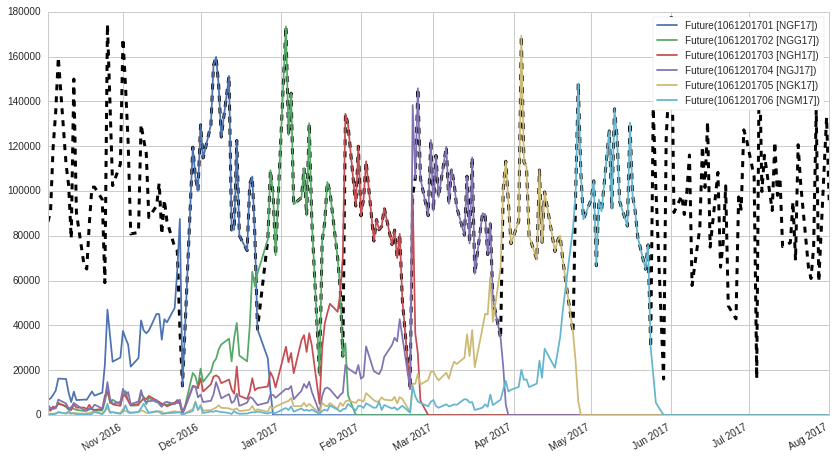

In [28]:
ax = ng_cont_active['volume'].plot(ls='--',c='black',lw=3)
ng_consecutive_contract_volume.plot(ax=ax)

In [31]:
ng_consecutive_contract_price = history(ng_contracts, 
                                         fields='price', 
                                         frequency='daily', 
                                         start='2016-10-01', 
                                         end='2017-08-01')

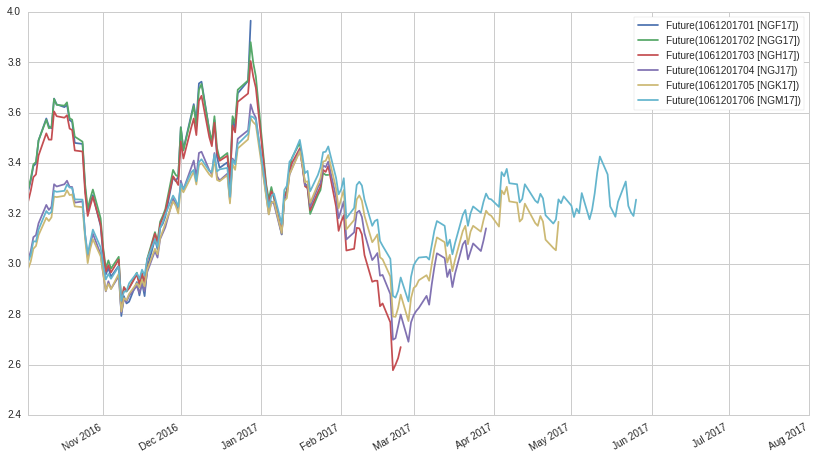

In [32]:
ng_consecutive_contract_price.plot()

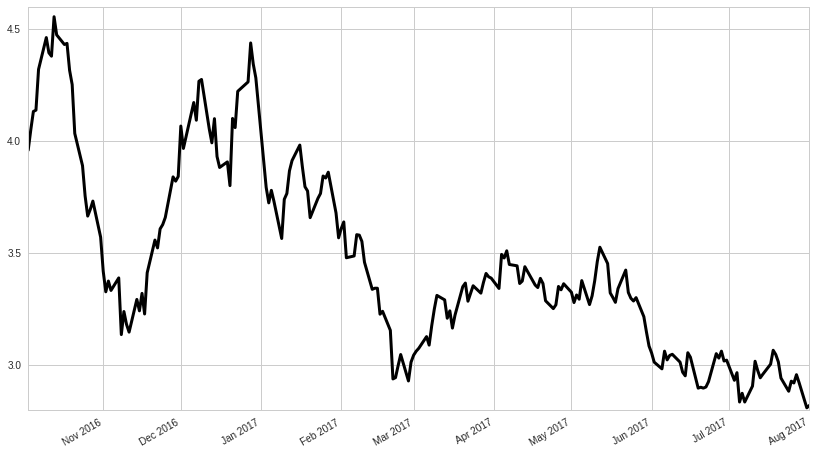

In [33]:
ng_cont_active['price'].plot(c='black',lw=3)

In [34]:
continuous_ng_unadjusted = continuous_future('NG', offset=0, roll='volume', adjustment=None)

In [36]:
ng_unadjusted_history = history(continuous_ng_unadjusted, 
                                fields=['contract', 'price'], 
                                frequency='daily', 
                                start='2016-10-01', 
                                end='2017-08-01')

In [37]:
ng_unadjusted_history.head()

,price,contract
2016-10-03 00:00:00+00:00,2.906,Future(1061201611 [NGX16])
2016-10-04 00:00:00+00:00,2.973,Future(1061201611 [NGX16])
2016-10-05 00:00:00+00:00,3.033,Future(1061201611 [NGX16])
2016-10-06 00:00:00+00:00,3.037,Future(1061201611 [NGX16])
2016-10-07 00:00:00+00:00,3.171,Future(1061201611 [NGX16])


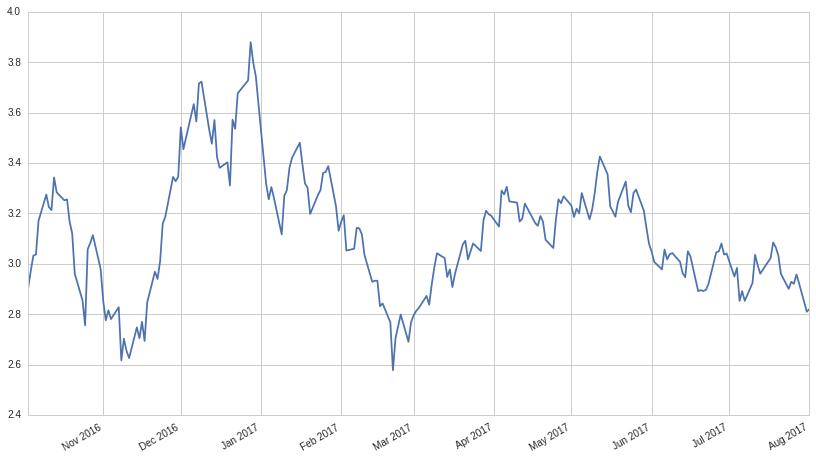

In [38]:
ng_unadjusted_history["price"].plot()

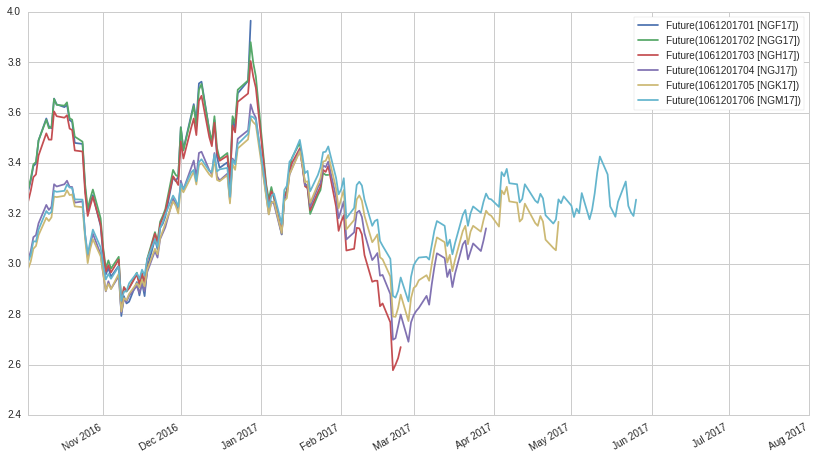

In [39]:
ng_consecutive_contract_price.plot()

In [42]:
pivot_unadj = ng_unadjusted_history.pivot(index=ng_unadjusted_history.index,columns='contract')

In [43]:
ng_unadjusted_history.head()

,price,contract
2016-10-03 00:00:00+00:00,2.906,Future(1061201611 [NGX16])
2016-10-04 00:00:00+00:00,2.973,Future(1061201611 [NGX16])
2016-10-05 00:00:00+00:00,3.033,Future(1061201611 [NGX16])
2016-10-06 00:00:00+00:00,3.037,Future(1061201611 [NGX16])
2016-10-07 00:00:00+00:00,3.171,Future(1061201611 [NGX16])


In [41]:
pivot_unadj.head()

price  \
contract                  Future(1061201611 [NGX16])   
2016-10-03 00:00:00+00:00                      2.906   
2016-10-04 00:00:00+00:00                      2.973   
2016-10-05 00:00:00+00:00                      3.033   
2016-10-06 00:00:00+00:00                      3.037   
2016-10-07 00:00:00+00:00                      3.171   

                                                      \
contract                  Future(1061201612 [NGZ16])   
2016-10-03 00:00:00+00:00                        NaN   
2016-10-04 00:00:00+00:00                        NaN   
2016-10-05 00:00:00+00:00                        NaN   
2016-10-06 00:00:00+00:00                        NaN   
2016-10-07 00:00:00+00:00                        NaN   

                                                      \
contract                  Future(1061201701 [NGF17])   
2016-10-03 00:00:00+00:00                        NaN   
2016-10-04 00:00:00+00:00                        NaN   
2016-10-05 00:00:00+00:00                        NaN   
2016-10-06 00:00:00+00:00                        NaN   
2016-10-07 00:00:00+00:00                        NaN   

                                                      \
contract                  Future(1061201702 [NGG17])   
2016-10-03 00:00:00+00:00                        NaN   
2016-10-04 00:00:00+00:00                        NaN   
2016-10-05 00:00:00+00:00                        NaN   
2016-10-06 00:00:00+00:00                        NaN   
2016-10-07 00:00:00+00:00                        NaN   

                                                      \
contract                  Future(1061201703 [NGH17])   
2016-10-03 00:00:00+00:00                        NaN   
2016-10-04 00:00:00+00:00                        NaN   
2016-10-05 00:00:00+00:00                        NaN   
2016-10-06 00:00:00+00:00                        NaN   
2016-10-07 00:00:00+00:00                        NaN   

                                                      \
contract                  Future(1061201704 [NGJ17])   
2016-10-03 00:00:00+00:00                        NaN   
2016-10-04 00:00:00+00:00                        NaN   
2016-10-05 00:00:00+00:00                        NaN   
2016-10-06 00:00:00+00:00                        NaN   
2016-10-07 00:00:00+00:00                        NaN   

                                                      \
contract                  Future(1061201705 [NGK17])   
2016-10-03 00:00:00+00:00                        NaN   
2016-10-04 00:00:00+00:00                        NaN   
2016-10-05 00:00:00+00:00                        NaN   
2016-10-06 00:00:00+00:00                        NaN   
2016-10-07 00:00:00+00:00                        NaN   

                                                      \
contract                  Future(1061201706 [NGM17])   
2016-10-03 00:00:00+00:00                        NaN   
2016-10-04 00:00:00+00:00                        NaN   
2016-10-05 00:00:00+00:00                        NaN   
2016-10-06 00:00:00+00:00                        NaN   
2016-10-07 00:00:00+00:00                        NaN   

                                                      \
contract                  Future(1061201707 [NGN17])   
2016-10-03 00:00:00+00:00                        NaN   
2016-10-04 00:00:00+00:00                        NaN   
2016-10-05 00:00:00+00:00                        NaN   
2016-10-06 00:00:00+00:00                        NaN   
2016-10-07 00:00:00+00:00                        NaN   

                                                      \
contract                  Future(1061201708 [NGQ17])   
2016-10-03 00:00:00+00:00                        NaN   
2016-10-04 00:00:00+00:00                        NaN   
2016-10-05 00:00:00+00:00                        NaN   
2016-10-06 00:00:00+00:00                        NaN   
2016-10-07 00:00:00+00:00                        NaN   

                                                      
contract                  Future(1061201709 [NGU17])  
2016-10

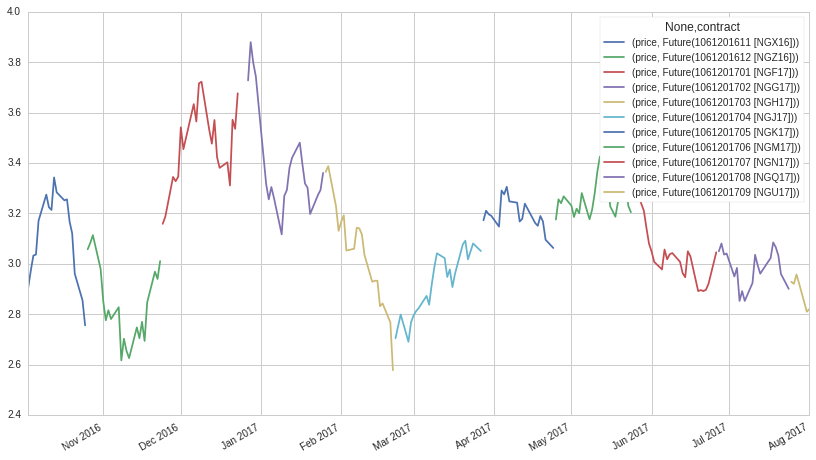

In [44]:
pivot_unadj.plot()

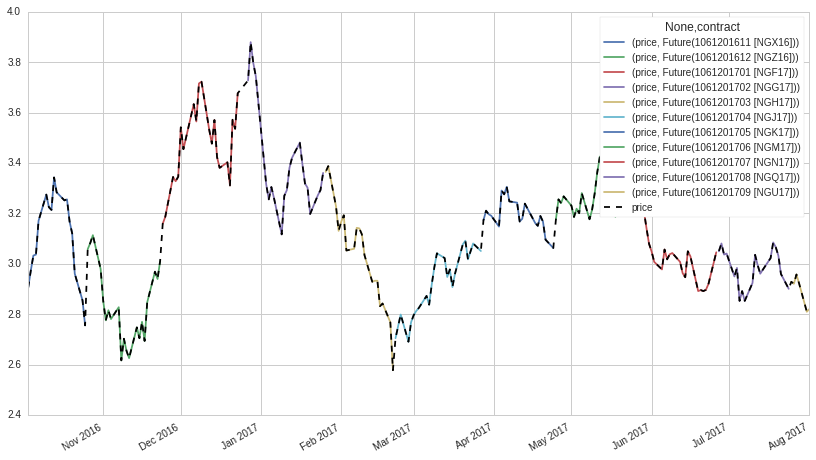

In [45]:
ax = pivot_unadj.plot()
ng_unadjusted_history.plot(ax=ax,ls='--',c='black')

## Adjustment Types

There are two main adjustment types, additive or multiplicative.

* Multiplicative adjustment, mul

This essentially computes the adjustment as the ratio of new contract price / old contract price whenever the active contract rolls to a new contract.

* Arithmetic adjustment, 'add'

The 'add' technique computes the adjustment as the difference new contract price - old contract price.